### 피드 포워드 신경망 구현하기

In [1]:
import numpy as np

# 데이터 생성하기
np.random.seed(seed = 1) # 난수 고정하기
N = 200 # 데이터의 수
K = 3
T = np.zeros((N, 3), dtype = np.uint8)
X = np.zeros((N, 2))
X_range0 = [-3, 3] # X0의 범위, 표시용
X_range1 = [-3, 3] # X1의 범위, 표시용
Mu= np.array([[-.5, -.5], [.5, 1.0], [1, -.5]]) # 분포의 중심
Sig = np.array([[.7, .7], [.8, .3], [.3, .8]]) # 분포의 분산
Pi = np.array([0.4, 0.8, 1]) # 각 분포에 대한  비율
for n in range(N):
    wk = np.random.rand()
    for k in range(K):
        if wk < Pi[k]:
            T[n, k] = 1
            break
    for k in range(2):
        X[n, k] = np.random.randn() * Sig[T[n, :] == 1, k] + \
        Mu[T[n, :] == 1, k]

In [13]:
# 분류 데이터를 테스트 훈련 데이터로 분할하기
TestRatio = 0.5
X_n_training = int(N * TestRatio)
X_train = X[:X_n_training, :]
X_test = X[X_n_training:, :]
T_train = T[:X_n_training, :]
T_test = T[X_n_training:, :]

# 데이터를 'class_data.npz'에 저장하기
np.savez('class_data.npz', X_trian=X_train, T_trian=T_train,
        X_test=X_test, T_test=T_test,
        X_range0=X_range0, X_range1=X_range1)

In [39]:
X_n_training

100

In [42]:
X

array([[-1.41738271e-01,  8.65336658e-01],
       [-8.69720227e-01, -1.25107804e+00],
       [-2.15442802e+00,  2.94741744e-01],
       [ 7.55231277e-01,  9.25188887e-01],
       [-1.10193462e+00,  7.40825341e-01],
       [ 2.42066237e-01,  8.84783694e-01],
       [ 1.21899268e+00, -2.01604969e-01],
       [ 9.48271538e-01, -1.20228673e+00],
       [ 1.57414612e+00, -2.35362296e-01],
       [ 1.31113504e-01, -1.48253963e-01],
       [-1.09503666e+00,  1.72574003e-01],
       [ 4.01687820e-01,  7.19269170e-01],
       [ 6.88588371e-01, -1.30758386e+00],
       [-9.81020890e-01, -1.09164395e+00],
       [ 5.82530397e-01,  8.13499946e-01],
       [ 6.61861524e-01,  1.94309124e-02],
       [ 6.84278289e-01, -1.02356762e+00],
       [ 5.40646204e-01,  8.08901306e-01],
       [ 1.04670738e+00,  1.00686579e+00],
       [ 7.40136256e-01,  8.94325046e-01],
       [ 3.73809851e-01, -1.03037190e+00],
       [ 7.28469860e-01,  1.26554235e+00],
       [-5.33250162e-01,  7.45526825e-01],
       [ 1.

In [41]:
X_train

array([[-0.14173827,  0.86533666],
       [-0.86972023, -1.25107804],
       [-2.15442802,  0.29474174],
       [ 0.75523128,  0.92518889],
       [-1.10193462,  0.74082534],
       [ 0.24206624,  0.88478369],
       [ 1.21899268, -0.20160497],
       [ 0.94827154, -1.20228673],
       [ 1.57414612, -0.2353623 ],
       [ 0.1311135 , -0.14825396],
       [-1.09503666,  0.172574  ],
       [ 0.40168782,  0.71926917],
       [ 0.68858837, -1.30758386],
       [-0.98102089, -1.09164395],
       [ 0.5825304 ,  0.81349995],
       [ 0.66186152,  0.01943091],
       [ 0.68427829, -1.02356762],
       [ 0.5406462 ,  0.80890131],
       [ 1.04670738,  1.00686579],
       [ 0.74013626,  0.89432505],
       [ 0.37380985, -1.0303719 ],
       [ 0.72846986,  1.26554235],
       [-0.53325016,  0.74552683],
       [ 1.14655544, -0.56045737],
       [-0.20438144,  1.08343865],
       [ 1.65567262, -1.61719707],
       [ 0.76004594,  0.93642612],
       [ 0.75250796,  0.39333964],
       [ 1.21527695,

### 3클래스 분류 문제의 인공 데이터

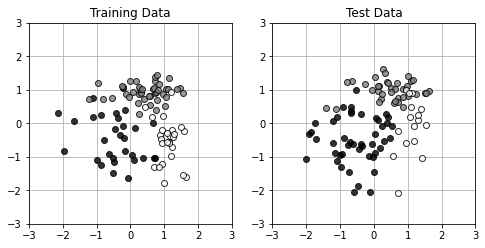

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

# 데이터 그리기
def Show_data(x, t):
    wk, n = t.shape
    c = [[0, 0, 0], [.5, .5, .5], [1, 1, 1]]
    for i in range(n):
        plt.plot(x[t[:, i] == 1, 0], x[t[:, i] == 1, 1],
                linestyle = 'none',
                marker = 'o', markeredgecolor = 'black',
                color = c[i], alpha = 0.8)
    plt.grid(True)
    
# 메인
plt.figure(1, figsize=(8, 3.7))
plt.subplot(1, 2, 1)
Show_data(X_train, T_train)
plt.xlim(X_range0)
plt.ylim(X_range1)
plt.title('Training Data')
plt.subplot(1, 2, 2)
Show_data(X_test, T_test)
plt.xlim(X_range0)
plt.ylim(X_range1)
plt.title('Test Data')
plt.show()

In [26]:
# 시그모이드 함수
def Sigmoid(x):
    y = 1 / (1 + np.exp(-x))
    return y

# 네트워크
def Fnn(wv, M, k, x):
    N, D = x.shape # 입력차원
    w = wv[:M * (D + 1)] # 중간층 뉴런의 가중치
    w = w.reshape(M, (D + 1))
    v = wv[M * (D + 1):] # 출력층 뉴런의 가중치
    v = v.reshape((K, M + 1))
    b = np.zeros((N, M + 1)) # 중간층 뉴런의 입력 총합
    z = np.zeros((N, M + 1)) # 중간층 뉴런의 출력
    a = np.zeros((N, K)) # 출력층 뉴런의 입력 총합
    y = np.zeros((N, K)) # 출력층 뉴런의 출력              
    for n in range(N):
        # 중간층 계산하기
        for m in range(M):
            b[n, m] = np.dot(w[m, :], np.r_[x[n, :], 1]) # (A)
            z[n, m] = Sigmoid(b[n, m])
        # 출력층의 계산
        z[n, M] = 1 # 더미 뉴런
        wkz = 0
        for k in range(K):
            a[n, k] = np.dot(v[k, :], z[n, :])
            wkz = wkz + np.exp(a[n, k])
        for k in range(K):
            y[n, k] = np.exp(a[n, k]) / wkz
    return y, a, z, b
                  
# test
WV = np.ones(15)
M = 2
K = 3
FNN(WV, M, K, X_train[:2, :])

(array([[0.33333333, 0.33333333, 0.33333333],
        [0.33333333, 0.33333333, 0.33333333]]),
 array([[2.6971835 , 2.6971835 , 2.6971835 ],
        [1.49172649, 1.49172649, 1.49172649]]),
 array([[0.84859175, 0.84859175, 1.        ],
        [0.24586324, 0.24586324, 1.        ]]),
 array([[ 1.72359839,  1.72359839,  0.        ],
        [-1.12079826, -1.12079826,  0.        ]]))

In [19]:
# 시그모이드 함수 ------------------------
def Sigmoid(x):
    y = 1/ (1 + np.exp(-x))
    return y
# 네트위크 ------------------------
def FNN(wv, M, K, x):
    N, D = x.shape # 입력 차원
    w = wv[:M * (D+1)] # 중간층 뉴런의 가중치
    w = w.reshape(M, (D+1))
    v = wv[M * (D+1):] # 출력층 뉴런의 가중치
    v = v.reshape((K, M + 1))
    b = np.zeros((N, M+1))
    z = np.zeros((N, M+1))
    a = np.zeros((N, K))
    y = np.zeros((N, K))
    for n in range(N):
        # 중간층의 계산
        for m in range(M):
            b[n,m] = np.dot(w[m,:], np.r_[x[n,:], 1]) # (A)
            z[n,m] = Sigmoid(b[n,m])
        # 출력층의 계산
        z[n,M] = 1 # 더미 뉴런
        wkz = 0
        for k in range(K):
            a[n,k] = np.dot(v[k,:], z[n,:])
            wkz = wkz + np.exp(a[n,k])
        for k in range(K):
            y[n,k] = np.exp(a[n,k]) / wkz
    return y, a, z, b
# test -------
WV = np.ones(15)
M = 2
K = 3
FNN(WV, M, K, X_train[:2, :])

(array([[0.33333333, 0.33333333, 0.33333333],
        [0.33333333, 0.33333333, 0.33333333]]),
 array([[2.6971835 , 2.6971835 , 2.6971835 ],
        [1.49172649, 1.49172649, 1.49172649]]),
 array([[0.84859175, 0.84859175, 1.        ],
        [0.24586324, 0.24586324, 1.        ]]),
 array([[ 1.72359839,  1.72359839,  0.        ],
        [-1.12079826, -1.12079826,  0.        ]]))

### 수치 미분법
- 평균 교차 엔트로피 오차를 다음의 CE_FNN 함수로 구현하기

In [28]:
# 수치 미분하기

def CE_FNN(wv, M, K, x, t):
    N, D = x.shape
    y, a, z, b = FNN(wv, M, K, x)
    ce = -np.dot(np.log(y.reshape(-1)), t.reshape(-1)) / N
    return ce
# test -------
WV = np.ones(15)
M = 2
K = 3
CE_FNN(WV, M, K, X_train[:2, :], T_train[:2, :])

1.0986122886681098

[ 0.0884813   0.19157999 -0.05139799  0.01281536 -0.14468029 -0.14242768
 -0.02992012  0.01351315 -0.11115648 -0.10104422 -0.09427964 -0.46855603
  0.13096434  0.08076649  0.57971252]


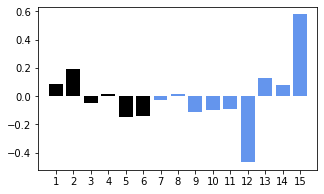

In [29]:
# - 수치 미분 -----------------
def dCE_FNN_num(wv, M, K, x, t):
    epsilon = .001
    dwv = np.zeros_like(wv)
    for iwv in range(len(wv)):
        wv_modified = wv.copy()
        wv_modified[iwv] = wv[iwv] - epsilon
        mse1 = CE_FNN(wv_modified, M, K, x, t)
        wv_modified[iwv] = wv[iwv] + epsilon
        mse2 = CE_FNN(wv_modified, M, K, x, t)
        dwv[iwv] = (mse2 - mse1) / (2 * epsilon)
    return dwv
# -- dvw의 표시 ---------------
def Show_WV(wv, M):
    N = wv.shape[0]
    plt.bar(range(1, M*3+1), wv[:M*3], align = "center", color = 'black')
    plt.bar(range(M*3+1, N+1), wv[M*3:], align = "center", color = 'cornflowerblue')
    plt.xticks(range(1, N+1))
    plt.xlim(0, N+1)
#-test-----------
M = 2
K = 3
nWV = M*3 + K * (M+1)
np.random.seed(1)
WV = np.random.normal(0,1,nWV)
dWV = dCE_FNN_num(WV, M, K, X_train[:2, :], T_train[:2, :])
print(dWV)
plt.figure(1, figsize=(5,3))
Show_WV(dWV, M)
plt.show()

In [43]:
import time

# 수치 미분을 사용한 경사 하강법
def Fit_FNN_num(wv_init, M, K, x_train, t_train, x_test, t_test, n, alpha):
    wvt = wv_init
    err_train = np.zeros(n)
    err_test = np.zeros(n)
    wv_hist = np.zeros((n, len(wv_init)))
    epsilon = 0.001
    for i in range(n): # (A)
        wvt = wvt - alpha *dCE_FNN_num(wvt,M, K, x_train, t_train)
        err_train[i] = CE_FNN(wvt, M, K, x_train, t_train)
        err_test[i] = CE_FNN(wvt, M, K, x_test, t_test)
        wv_hist[i, :] = wvt
    return wvt, wv_hist, err_train, err_test

# 메인
        
startTime = time.time()
M = 2
K = 3
np.random.seed(1)
WV_init = np.random.normal(0, 0.01, M *3 +K *(M +1))
N_step = 1000 # (B) 학습 단계
alpha = 0.5
WV, WV_hist, Err_train, Err_test = Fit_FNN_num(
    WV_init, M, K, X_train, T_train, X_test, T_test, N_step, alpha)
calculation_time = time.time() - startTime
print("Calculation time:{0:.3f}sec".format(calculation_time))

Calculation time:136.490sec


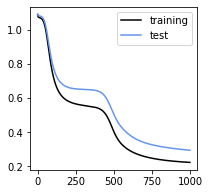

In [44]:
# 학습 오차 표시
plt.figure(1, figsize=(3,3))
plt.plot(Err_train, 'black', label = 'training')
plt.plot(Err_test, 'cornflowerblue', label = 'test')
plt.legend()
plt.show()

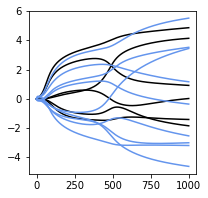

In [45]:
# 가중치의 시간 변화의 표시
plt.figure(1, figsize= (3, 3))
plt.plot(WV_hist[:, :M*3], 'black')
plt.plot(WV_hist[:, M*3:], 'cornflowerblue')
plt.show()

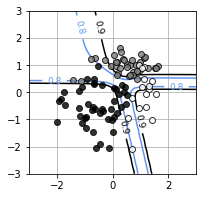

In [49]:
# 경계선 표시 함수
def show_FNN(wv, M, K):
    xn = 60 # 등고선 표시 해상도
    x0 = np.linspace(X_range0[0], X_range0[1], xn)
    x1 = np.linspace(X_range1[0], X_range1[1], xn)
    xx0, xx1 = np.meshgrid(x0, x1)
    x = np.c_[np.reshape(xx0, xn *xn, 'F'), np.reshape(xx1, xn * xn, 'F')]
    y, a, z, b = FNN(wv,M, K, x)
    plt.figure(1, figsize =(4,4))
    for ic in range(K):
        f = y[:, ic]
        f = f.reshape(xn, xn)
        f = f.T
        cont = plt.contour(xx0, xx1, f, levels = [0.8, 0.9], 
                           colors=['cornflowerblue', 'black'])
        cont.clabel(fmt='%1.1f', fontsize=9)
    plt.xlim(X_range0)
    plt.xlim(X_range1)
        
# 경계선 표시
plt.figure(1, figsize=(3,3))
Show_data(X_test, T_test)
show_FNN(WV, M ,K)
plt.show()